In [6]:
## Demarrage du projet ##
1+1 #Ca porte chance

2

In [7]:
from Data import DataLoader
from Data import RadarDataSet
from PreProcessing.domaines.passage_freq import get_signal_frequentiel
from Models.PolynomialRegressor import PolynomialRegressor
from Models.BasicNNModel import BasicNNModel
from Models.DocuCNNModel import DocuCNNModel
from Models.ArticleProfCNN2D import ArticleProfCNN2D 
from Models.BasicAutoEncoder import BasicAutoEncoder
from PreProcessing.utils import data_to_complex
from sklearn.preprocessing import StandardScaler
from Evaluation.plots import ErrorOfSNRPlot 
from Evaluation.plots import PredictedStepPlot, LearningCurvesPlot
from Evaluation.statistic_errors import MSEEvaluateur, RMSEEvaluateur, R2Score, Accuracy
from Evaluation.plots import MusicVsModelBySNR
from Models.MUSIC import MUSICModel
import keras
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

## Chargement de la dataset

In [8]:

absolutePath = "./Data/"
data_loader2 = DataLoader.DataLoader(absolutePath+"last_data/Dataset_X5690_30-30_2S_test.csv",absolutePath+"last_data/Dataset_y5690_30-30_2S_test.csv")
data2, labels2 = data_loader2.load_data()
radar_dataset2 = RadarDataSet.RealImaginaryXDataSet(data2,labels2,0.4, StandardScaler(),appended_snr=True)

## Visualisation de la distribution de la dataset

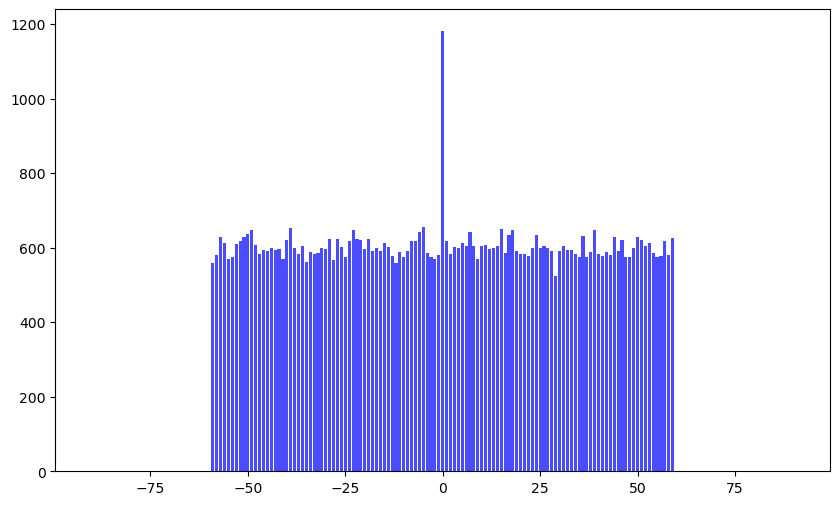

In [9]:
#Distribution des labels de la dataset
radar_dataset2.plot_labels_distribution()

## Chargement du modèle

In [10]:
docuCNNModel = DocuCNNModel()
keras.utils.get_custom_objects()['angleSensitiveCustomLoss'] = docuCNNModel.Trainer.angleSensitiveCustomLoss
docuCNNModel.load("CNN_docu10_XRI_e30_b350_anglesensitive_2S",custom_loss="angleSensitiveCustomLoss")

## Prédiction sur les données de test + applicage d'un seuil

In [ ]:
threshold = 0.8
y_predicted2 = docuCNNModel.model.predict(radar_dataset2.X)
y_predicted_binary2 = (y_predicted2> threshold).astype(int)

##Visualisation de métriques par niveaux de bruits

In [ ]:
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2)
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="accuracy_score")
ErrorOfSNRPlot().evaluate(radar_dataset2.snr_y, radar_dataset2.y, y_predicted_binary2, errorFunc="roc_auc_score")
Accuracy().evaluate(radar_dataset2.y, y_predicted_binary2)



## Tirage aléatoire d'un exemple dans le test set pour visualisation

In [ ]:
#plot random index
randomTestIndex = random.randint(0, len(radar_dataset2.y))
PredictedStepPlot().evaluate(
    radar_dataset2.y[randomTestIndex], y_predicted2[randomTestIndex], threshold = threshold
)

## Recherche de threshold optimal, su des dataset à SNR entre -5 et 30

In [ ]:
yp_test = docuCNNModel.model.predict(radar_dataset2.X_test)
TRESHOLDArray= np.arange(0,1,0.05)
accuracyOfTreshold = [f1_score(radar_dataset2.y_test, (yp_test> tresh).astype(int), average="samples") for tresh in TRESHOLDArray]
index_of_peak = np.argmax(accuracyOfTreshold)
peak_value = accuracyOfTreshold[index_of_peak]
plt.plot(TRESHOLDArray,accuracyOfTreshold)
plt.scatter(TRESHOLDArray[index_of_peak], peak_value, color='red', label='Pic')

## Comparaison des performances avec l'algorithme MUSIC

In [ ]:
#Necessité de recharger des données car MUSIC ne prend pas les données normalisées
radar_dataset_rxx = RadarDataSet.RxxDataSet(data2,labels2,0.4, scaler=None,appended_snr=True)
musicModel = MUSICModel(2, np.arange(-90,91,1))
y_music_predicted_angles, y_music_predicted_multilabel = musicModel.predict(radar_dataset_rxx.X)

In [ ]:
musicVsModelBySNRPlotter = MusicVsModelBySNR(step=1, errorFunc="rmse") #Illustrer le CRB limite theorique
musicVsModelBySNRPlotter.evaluate(radar_dataset_rxx.snr_y,radar_dataset_rxx.y,y_music_predicted_multilabel,radar_dataset2.snr_y, radar_dataset2.y, y_predicted2)